In [1138]:
# https://arxiv.org/pdf/1903.07320.pdf

In [1139]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (12, 6)

In [1140]:
import gpflow
import tensorflow as tf

In [1141]:
def hifi_model(x):
    return (6*x - 2)**2 * np.sin(12*x-4)

In [1142]:
def lofi_model(x):
    return 0.5*hifi_model(x) + 10*(x-0.5) + 5

In [1143]:
x_true = np.linspace(0, 1, 100)[:,np.newaxis]

In [1144]:
lofi_true = lofi_model(x_true)
hifi_true = hifi_model(x_true)

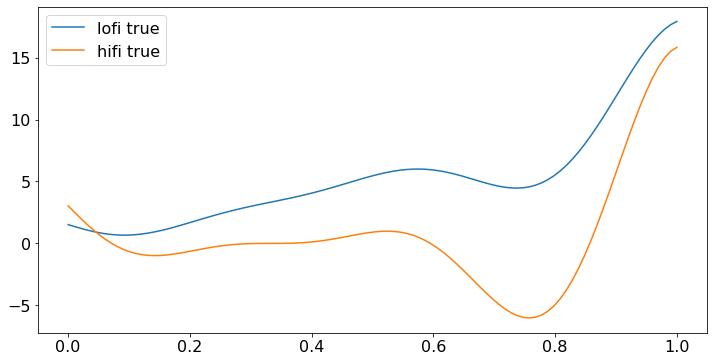

In [1145]:
plt.figure()
plt.plot(x_true, lofi_true, label='lofi true')
plt.plot(x_true, hifi_true, label='hifi true')
plt.legend()

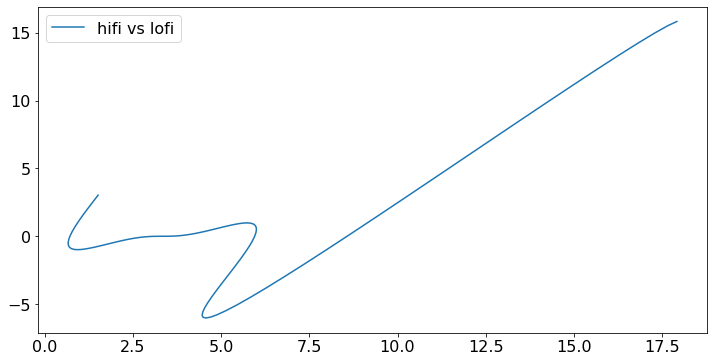

In [1146]:
# Figure 6 in B.1: 1903.07320
plt.figure()
plt.plot(lofi_true, hifi_true, label='hifi vs lofi')
plt.legend()

# bridge functions

In [1147]:
def bridge_additive(lofi, hifi):
    return hifi-lofi

In [1148]:
def bridge_mult(lofi, hifi):
    return hifi/lofi

In [1149]:
def mfm_additive(lofi, bridge):
    return lofi + bridge

In [1150]:
def mfm_mult(lofi, bridge):
    return lofi * bridge

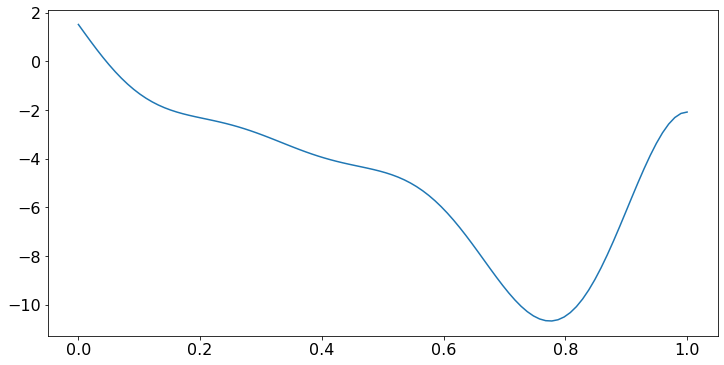

In [1151]:
plt.figure()
plt.plot(x_true, bridge_additive(lofi_true, hifi_true))

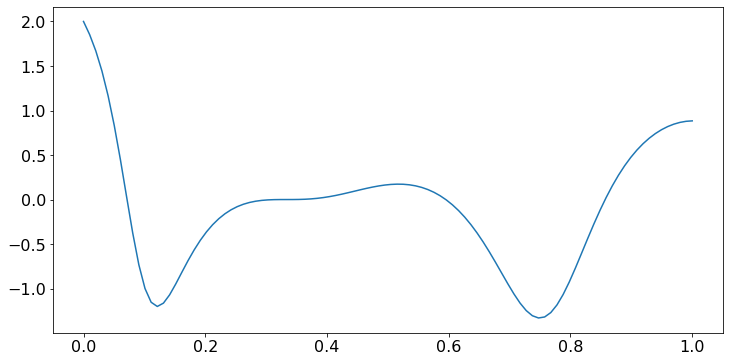

In [1152]:
plt.figure()
plt.plot(x_true, bridge_mult(lofi_true, hifi_true))

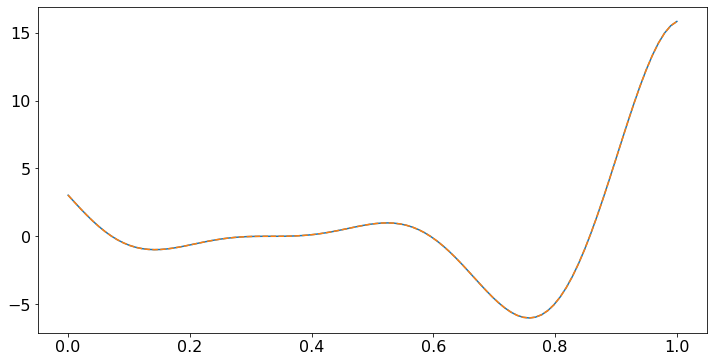

In [1153]:
plt.figure()
plt.plot(x_true, hifi_true)
plt.plot(x_true, mfm_additive(lofi_true, bridge_additive(lofi_true, hifi_true)), ls='--')

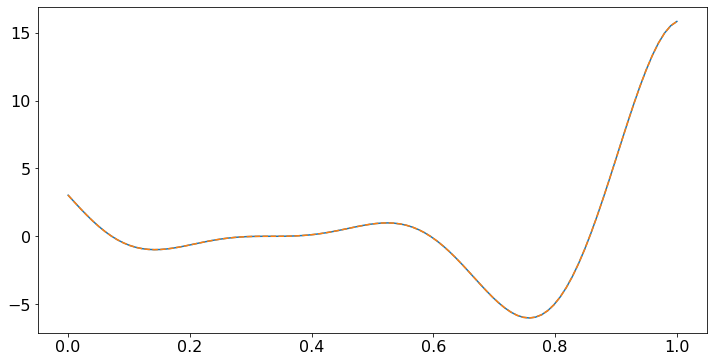

In [1154]:
plt.figure()
plt.plot(x_true, hifi_true)
plt.plot(x_true, mfm_mult(lofi_true, bridge_mult(lofi_true, hifi_true)), ls='--')

# train and test data

In [1155]:
# lofi_x = np.sort(np.random.uniform(size=(100, 1)), axis=0)
lofi_x = np.linspace(0, 1, 20)[:,np.newaxis]
train_lofi = lofi_model(lofi_x)

In [1156]:
train_x = np.sort(np.random.uniform(size=(5, 1)), axis=0)
# train_x = np.array([0.1, 0.2, 0.65, 0.7, 0.8, 0.9])[:,np.newaxis]
# test_x = np.sort(np.random.uniform(size=(20, 1)), axis=0)

In [1157]:
train_hifi = hifi_model(train_x)
# test_hifi = hifi_model(test_x)

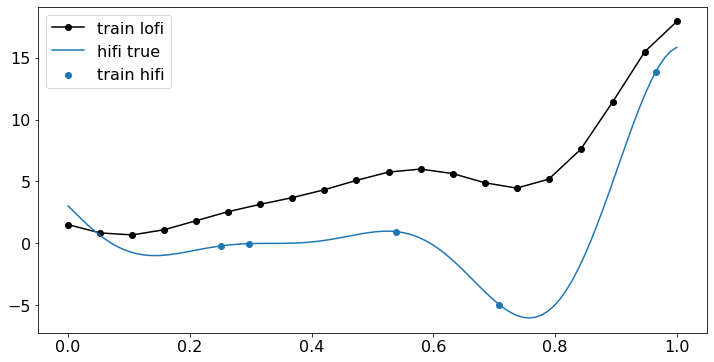

In [1158]:
plt.figure()

plt.plot(lofi_x, train_lofi, 'k-o', label='train lofi')
plt.plot(x_true, hifi_true, label='hifi true')

plt.scatter(train_x, train_hifi, label='train hifi')
# plt.scatter(test_x, test_hifi, label='test hifi')

plt.legend()

# gpr fits

In [1159]:
def fit_gp(X, Y):
    k = gpflow.kernels.Matern52()
#     k = gpflow.kernels.RBF()
    m = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=None)
    m.likelihood.variance.assign(0.01)
    m.kernel.lengthscales.assign(0.3)
    # by default using the L-BFGS-B
    opt = gpflow.optimizers.Scipy()
    opt_logs = opt.minimize(m.training_loss, m.trainable_variables, options=dict(maxiter=100))

    return m

In [1160]:
def plot_gpr(X, y, gp):
    
    xx = np.linspace(-0.1, 1.1, 1000).reshape(-1, 1)  # test points must be of shape (N, D)
    
    mean, var = gp.predict_f(xx)
    
    plt.figure()
    plt.plot(X, y,' go',markerfacecolor='none', label='data')

    plt.plot(xx, mean, "C0", lw=2)
    plt.fill_between(
        xx[:, 0],
        mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
        mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
        color="C0",
        alpha=0.2,
    )

    
    plt.legend()

In [1161]:
def fit_and_plot(X, y):
    gp = fit_gp(X, y)
    plot_gpr(X, y, gp)
    return gp

In [1162]:
# for multifidelity modelling we make GPR fits for lofi and the bridge function
# we will also make a GPR fit for the hifi training test to compare

In [1163]:
# np.save("test-lofi.npy", np.stack((lofi_x[:,0], train_lofi)))

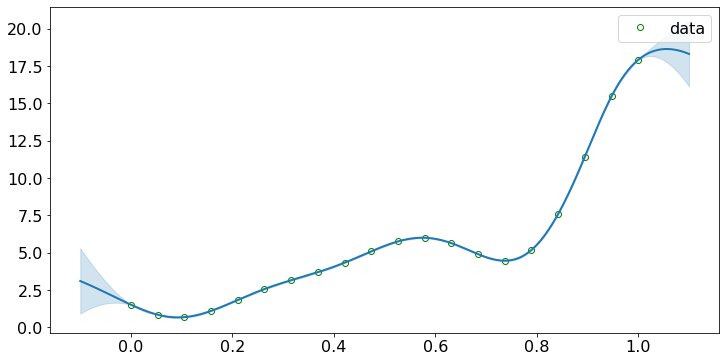

In [1164]:
# GPR lofi
lofi_gp = fit_and_plot(lofi_x, train_lofi)

In [1165]:
# make brdige data
mu, _  = lofi_gp.predict_f(train_x)
train_brdige = bridge_additive(mu ,train_hifi)

In [1166]:
# np.save("test-bridge.npy", np.stack((train_x[:,0], train_brdige)))

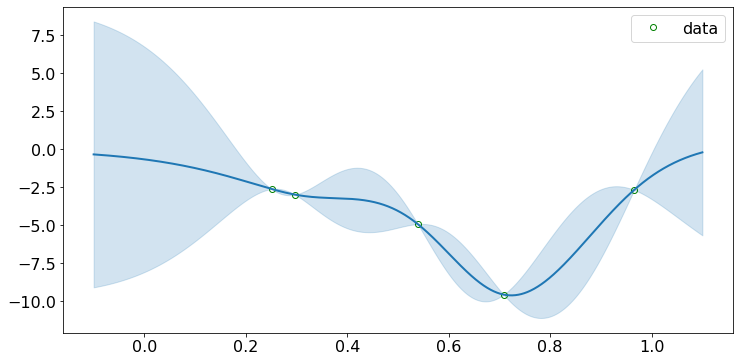

In [1167]:
# GPR bridge
bridge_gp = fit_and_plot(train_x, train_brdige)

In [1168]:
# np.save("test-hifi.npy", np.stack((train_x[:,0], train_hifi)))

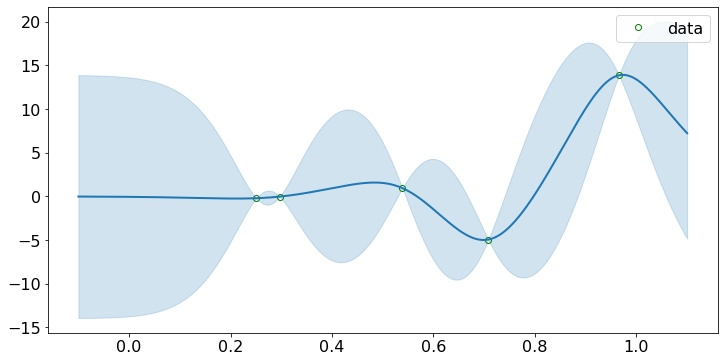

In [1169]:
# GPR hifi so that we can compare
# this data has caused me trouble fitting
hifi_gp = fit_and_plot(train_x, train_hifi)

In [1170]:
# multifidelity model: mfm
def mfm_predict(x, lofi_gp, bridge_gp , bridge_func):
    lofi_mu, lofi_var = lofi_gp.predict_f(x)
    bridge_mu, bridge_var = bridge_gp.predict_f(x)
    return lofi_mu, bridge_mu, bridge_func(lofi_mu, bridge_mu), bridge_func(lofi_var, bridge_var)

In [1171]:
lofi_mu, bridge_mu, mfm, mfm_var = mfm_predict(x_true,
                                      lofi_gp,
                                      bridge_gp,
                                      bridge_func=mfm_additive)

In [1172]:
gp_hifi_mu, gp_hifi_var = hifi_gp.predict_f(x_true)

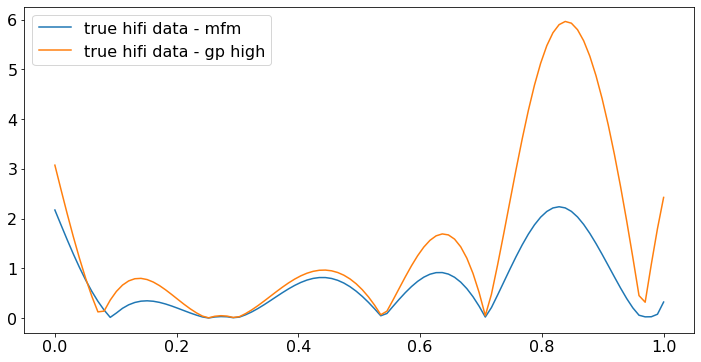

In [1173]:
plt.figure(figsize=(12, 6))
plt.plot(x_true, np.abs(hifi_true-mfm), label='true hifi data - mfm')
plt.plot(x_true, np.abs(hifi_true-(gp_hifi_mu)), label='true hifi data - gp high')
plt.legend()
# plt.yscale('log')

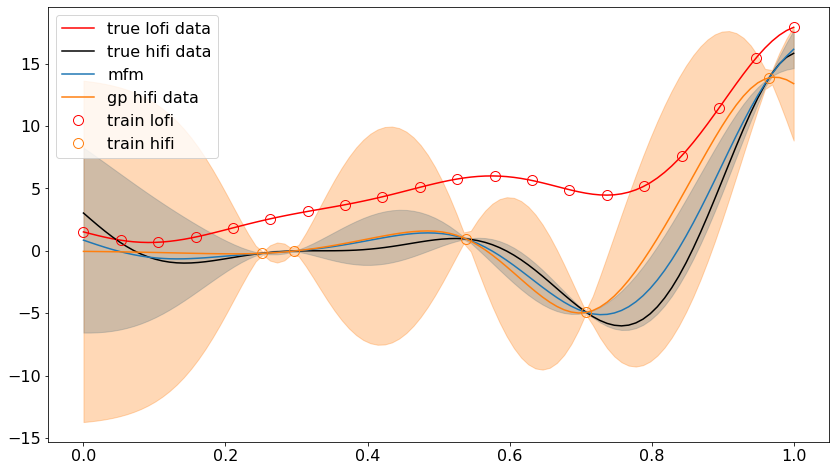

In [1174]:
plt.figure(figsize=(14, 8))
plt.plot(x_true, lofi_true, label='true lofi data', c='r')
plt.plot(x_true, hifi_true, label='true hifi data', c='k')

plt.plot(x_true, mfm, label='mfm', c='C0')
plt.fill_between(x_true[:,0],
                 (mfm[:,0] - 1.96*np.sqrt(mfm_var[:,0])),
                 (mfm[:,0] + 1.96*np.sqrt(mfm_var[:,0])),
                 alpha=0.3, color='C0')

plt.plot(x_true, gp_hifi_mu, label='gp hifi data', c='C1')
plt.fill_between(x_true[:,0],
                 (gp_hifi_mu[:,0] - 1.96*np.sqrt(gp_hifi_var[:,0])),
                 (gp_hifi_mu[:,0] + 1.96*np.sqrt(gp_hifi_var[:,0])),
                 alpha=0.3, color='C1')


plt.plot(lofi_x, train_lofi, 'ro', label='train lofi', markerfacecolor='none', markersize=10)
plt.plot(train_x, train_hifi, 'o', c='C1', label='train hifi', markerfacecolor='none', markersize=10)


plt.legend()

In [1175]:
# we find that the multifidelity model outperforms the GPR model that was trained only on the hifi data.